## Preparation

Make sure that your Colab Notebook has access to a GPU!

In [1]:
# install required libraries via pip

!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries

import gensim.downloader
import os
import torch
import numpy as np

from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

## Stable Diffusion (Text to Image)

In [1]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe = pipe.to('cuda')

NameError: ignored

  0%|          | 0/50 [00:00<?, ?it/s]

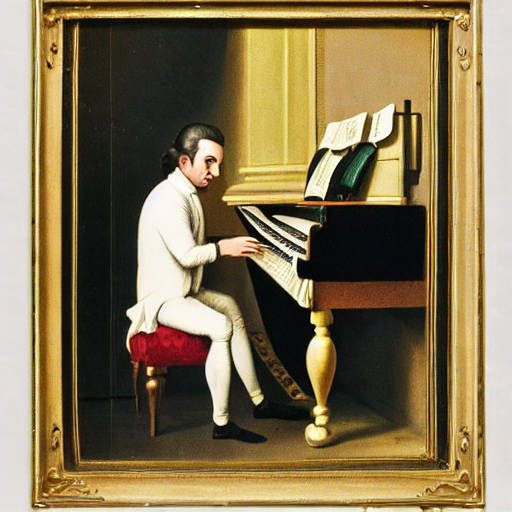

In [5]:
initial_caption = 'Mozart playing Piano'
image1 = pipe(initial_caption).images[0]

image1.save('image1.png')

image1.show()

## Blip (Image to text)

In [5]:
# TODO: Might be worth to try the conditional formatting?

# conditional image captioning
#text = "a photography of"
#inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

#out = model.generate(**inputs)
#print(processor.decode(out[0], skip_special_tokens=True))
# >>> a photography of a woman and her dog

# unconditional image captioning

In [6]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")
 
raw_image = Image.open('image1.png').convert('RGB')


In [7]:
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
image1_caption = processor.decode(out[0], skip_special_tokens=True)
print(image1_caption)

a painting of a man playing the piano


## Comparison

In [8]:
# Download Google News Word Embedding. If it's downloaded already it won't do it again!

embedding_path = 'embeddings/word2vec-google-news-300.bin'
embedding_name = 'word2vec-google-news-300'

if os.path.exists(embedding_path):
    print("Word Embedding has been downloaded already.")
else:
  google_news_embedding = gensim.downloader.load(embedding_name)
  google_news_embedding.save(embedding_path)


Word Embedding has been downloaded already.


In [9]:
google_news_word_embedding = gensim.models.KeyedVectors.load(embedding_path)

def get_mean_vector(sentence, word_embedding):
  tokens = sentence.split()
  embedding = [word_embedding[word] for word in tokens if word in word_embedding]

  if len(embedding) > 0:
    return np.mean(embedding, axis=0)
  else:
    return None

initial_caption_mv = get_mean_vector(initial_caption, google_news_word_embedding)
image1_caption_mv = get_mean_vector(image1_caption, google_news_word_embedding)

## Results

Similarity between the sentences: 0.6496886014938354

Initial Caption: Mozart playing Piano

Image 1:


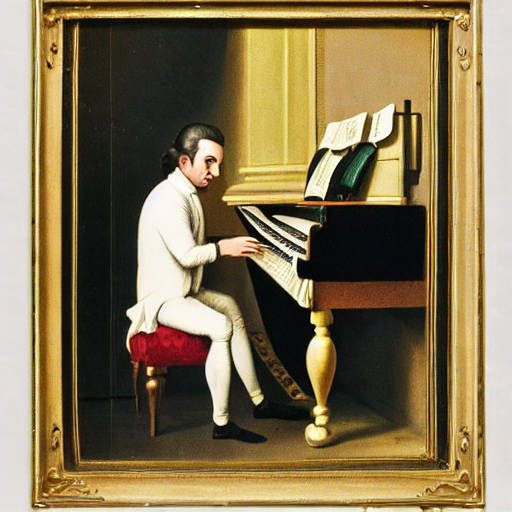


Image 1 Caption: a painting of a man playing the piano



In [10]:
# print(f'Initial Caption Mean Vector: {initial_caption_mv}')
# print(f'Image 1 Caption Mean Vector: {image1_caption_mv}')

def calculate_mv_similarity(sentence_1_mv, sentence_2_mv):
  if sentence_1_mv is not None and sentence_2_mv is not None:
    similarity = 1 - cosine(initial_caption_mv, image1_caption_mv)
    print("Similarity between the sentences:", similarity)
  else:
    print("One or both sentence embeddings could not be calculated.")


calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

print(f'\nInitial Caption: {initial_caption}\n')
print(f'Image 1:')
image1.show()
print(f'\nImage 1 Caption: {image1_caption}\n')